# Cognitive Portrait - Advanced


In [21]:
import mPyPl as mp
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [10]:
dir = 'z:/temp/pics'
target_triangle_1 = [(500,300),(800,300),(650,600)]
target_triangle_2 = [(800,300),(1100,300),(950,600)]

In [5]:
def loadjs(fn):
    with open(fn) as f:
        return json.load(f)

In [8]:
data = (
    mp.get_files(dir,ext='.json')
    | mp.as_field('filename')
    | mp.apply('filename','descr',loadjs)
    | mp.unroll('descr')
    | mp.filter('descr',lambda x: abs(x['faceAttributes']['headPose']['yaw'])<15 and abs(x['faceAttributes']['headPose']['pitch'])<15)
    | mp.filter('descr',lambda x: x['faceLandmarks']['pupilRight']['x']-x['faceLandmarks']['pupilLeft']['x']>50)
    | mp.as_list)

In [9]:
data[0]

{'filename': 'z:/temp/pics\\AGAA9381.json',
 'descr': {'faceId': '7645f364-3d5e-4fd1-998b-62a40236d239',
  'faceRectangle': {'top': 1425, 'left': 1197, 'width': 298, 'height': 298},
  'faceLandmarks': {'pupilLeft': {'x': 1282.7, 'y': 1500.4},
   'pupilRight': {'x': 1414.0, 'y': 1506.6},
   'noseTip': {'x': 1344.0, 'y': 1588.6},
   'mouthLeft': {'x': 1288.8, 'y': 1645.4},
   'mouthRight': {'x': 1399.5, 'y': 1645.9},
   'eyebrowLeftOuter': {'x': 1225.0, 'y': 1476.6},
   'eyebrowLeftInner': {'x': 1310.5, 'y': 1481.4},
   'eyeLeftOuter': {'x': 1259.0, 'y': 1501.3},
   'eyeLeftTop': {'x': 1282.3, 'y': 1492.3},
   'eyeLeftBottom': {'x': 1280.1, 'y': 1510.4},
   'eyeLeftInner': {'x': 1302.6, 'y': 1504.8},
   'eyebrowRightInner': {'x': 1376.5, 'y': 1482.8},
   'eyebrowRightOuter': {'x': 1473.4, 'y': 1487.9},
   'eyeRightInner': {'x': 1393.9, 'y': 1508.0},
   'eyeRightTop': {'x': 1415.2, 'y': 1497.8},
   'eyeRightBottom': {'x': 1414.3, 'y': 1515.9},
   'eyeRightOuter': {'x': 1437.3, 'y': 1510.0

In [19]:
def get_transform(descr):
    f = descr['faceLandmarks']
    g = descr['faceAttributes']['gender'] == 'male'
    mc_x = (f['mouthLeft']['x']+f['mouthRight']['x'])/2.0
    mc_y = (f['mouthLeft']['y'] + f['mouthRight']['y']) / 2.0
    return cv2.getAffineTransform(np.float32([(f['pupilLeft']['x'],f['pupilLeft']['y']),(f['pupilRight']['x'],f['pupilRight']['y']),(mc_x,mc_y)]),
                                np.float32(target_triangle_1 if g else target_triangle_2))

def transform(args):
    image,descr = args
    tr = get_transform(descr)
    return cv2.warpAffine(image,tr,(1600,900))


def merge(images,wts=None):
    images = list(images)
    res = np.zeros_like(images[0],dtype=np.float32)
    if wts is None:
        wts = np.ones(len(images))
    wts /= np.sum(wts)
    for n,i in enumerate(images):
        res += wts[n]*i.astype(np.float32)
    return res.astype(np.int32)

In [52]:
@mp.Pipe
def balance(seq,sel,n=None):
    d = {}
    for x in seq:
        v = x[sel] if isinstance(sel,str) else sel(x)
        if v in d.keys():
            d[v].append(x)
        else:
            d[v] = [x]
    if n is None:
        n = min([len(v) for i,v in d.items()])
    else:
        n = min(n,min([len(v) for i,v in d.items()]))
    for i in range(n):
        for k,v in d.items():
            yield v[i]

In [53]:
sign = cv2.imread('Mit2020.png',cv2.IMREAD_UNCHANGED)
sign = cv2.resize(sign,(120,120))

def imprint(img):
    overlay_image = sign[..., :3]
    mask = sign[..., 3:] / 255.0
    h,w = sign.shape[0],sign.shape[1]
    x,y=1600-h,900-w
    img[y:y+h, x:x+w] = (1.0 - mask) * img[y:y+h, x:x+w] + mask * overlay_image
    return img

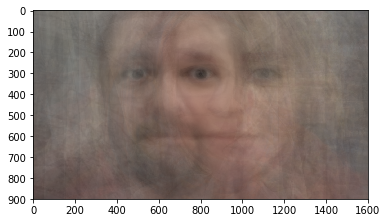

In [59]:
img = (data
| mp.pshuffle
| balance(lambda x: x['descr']['faceAttributes']['gender'],n=20)
| mp.apply('filename','image',lambda x: cv2.cvtColor(cv2.imread(os.path.splitext(x)[0]+'.jpg'),cv2.COLOR_BGR2RGB))
| mp.apply(['image','descr'],'face',transform)
| mp.select_field('face')
| mp.pexec(merge))

plt.imshow(img)

In [60]:
cv2.imwrite('e:/sciart/MandF3.jpg',imprint(cv2.cvtColor(img.astype('uint8'),cv2.COLOR_BGR2RGB)))

True